### Loading packages

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

Global seed set to 0


In [2]:
import gc
import torch

In [18]:
import os

## Functions

In [3]:
def read_and_qc(sample_name, path):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join='-')
    
    adata.obs['sample'] = sample_name
    
    # rename genes to ENSEMBL
    adata.var['SYMBOL'] = adata.var_names
    adata.var_names = adata.var['gene_ids']
    adata.var_names.name = None

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('MT-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

## Read in metadata

In [4]:
meta=pd.read_csv('/nfs/team205/heart/anndata_objects/Foetal/metadata/HeartTeamSamples_Mappeddata_20230208_for-cell2loc.csv',
                index_col=0)
meta

,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed,status,cell2loc-map_group
Publication,,,,,,,,,,,,,,,
Foetal,BHF_F_Hea13295830,na,Hst45,na,Heart,Heart,PCW-16w,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW
Foetal,BHF_F_Hea13295831,na,Hst45,na,Heart,Heart,PCW-16w,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW
Foetal,HCAHeartST10298114,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298115,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298116,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298117,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298118,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW_DA
Foetal,HCAHeartST10298119,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW_DA
Foetal,HCAHeartST10298120,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW


In [5]:
pd.crosstab(meta['donor'],meta['cell2loc-map_group'])

cell2loc-map_group,13PCW,20PCW,4PCW,5PCW,7PCW,7PCW_DA,FFPE_16PCW,T21_13PCW
donor,,,,,,,,
C104,0,0,1,0,0,0,0,0
C83,0,0,0,0,10,5,0,0
C92,0,0,0,2,0,0,0,0
Hst33,2,0,0,0,0,0,0,0
Hst41,0,3,0,0,0,0,0,0
Hst44,0,0,0,0,0,0,0,4
Hst45,0,0,0,0,0,0,2,0


In [6]:
# select slides
# Healthy, OCT, and without DA
meta = meta[meta['cell2loc-map_group'].isin(['4PCW','5PCW','7PCW','13PCW','20PCW'])]

sampleIDs = list(meta['sangerID'])
len(sampleIDs)

18

## Data, parameters

In [8]:
results_folder = '/nfs/team205/heart/cell2location/foetal'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures/ver28Feb2023/whole_woPeriCell_woDASMC'
run_name = f'{results_folder}/cell2location_map/ver28Feb2023'

In [9]:
visium_path='/nfs/team205/heart/mapped/spaceranger110/'

celltype_key='fine_grain'

## Loading visium data

In [10]:
# Read the data of the interested region into anndata objects
slides = []
for i in sampleIDs:
    slides.append(read_and_qc(i, path=visium_path))

# Combine anndata objects together
adata_vis = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sampleIDs,
    index_unique=None
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Vari

Trying to set attribute `._uns` of view, copying.
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._

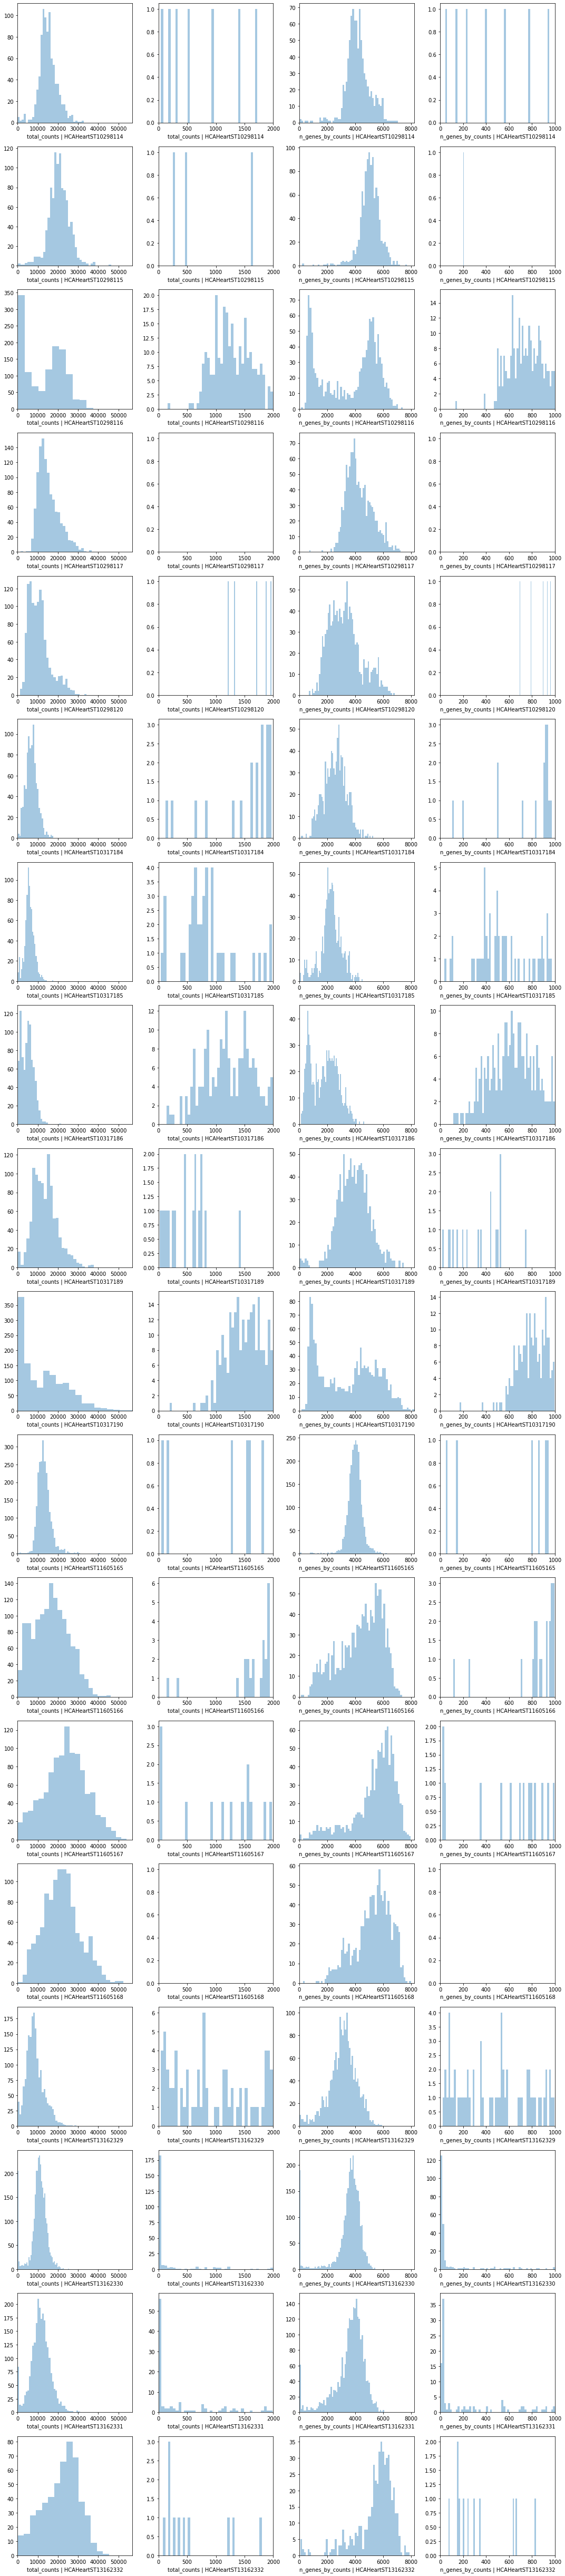

In [11]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i, s in enumerate(adata_vis.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')

    slide = select_slide(adata_vis, s)
    sns.distplot(slide.obs['total_counts'],
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata_vis.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<2000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 2000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata_vis.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<1000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 1000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')

plt.tight_layout()

## Filter out low quality spots

In [12]:
# filter out low quality spots
sc.pp.filter_cells(adata_vis, min_counts = 500)
sc.pp.filter_cells(adata_vis, min_genes = 300)

# Spot number per slide
adata_vis.obs['sample'].value_counts()

HCAHeartST13162330    2806
HCAHeartST11605165    2429
HCAHeartST13162331    2338
HCAHeartST13162329    1777
HCAHeartST10317190    1337
HCAHeartST11605166    1321
HCAHeartST10298116    1219
HCAHeartST10298120    1170
HCAHeartST10298117    1126
HCAHeartST11605168    1082
HCAHeartST11605167    1044
HCAHeartST10298115    1025
HCAHeartST10317189    1004
HCAHeartST10317184     897
HCAHeartST10298114     872
HCAHeartST10317186     855
HCAHeartST10317185     824
HCAHeartST13162332     505
Name: sample, dtype: int64

## Remove mitochondrial genes

In [13]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]
print(sum(adata_vis.var['MT_gene']))
    
# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]
print(sum(adata_vis.var['MT_gene']))

13
0


In [14]:
meta.head()

,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed,status,cell2loc-map_group
Publication,,,,,,,,,,,,,,,
Foetal,HCAHeartST10298114,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298115,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298116,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298117,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298120,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW


## Add metadata and annotation

In [15]:
adata_vis.obs = adata_vis.obs.reset_index().merge(meta, how='left', left_on='sample', right_on='sangerID').set_index('spot_id')
adata_vis

AnnData object with n_obs × n_vars = 23631 × 33525
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'mt', 'n_cells_by_counts-HCAHeartST10298114', 'mean_counts-HCAHeartST10298114', 'log1p_mean_counts-HCAHeartST10298114', 'pct_dropout_by_counts-HCAHeartST10298114', 'total_counts-HCAHeartST10298114', 'log1p_total_counts-HCAHeartST10298114', 'n_cells_by_counts-HCAHeartST10298115', 'mean_counts-HCAHeartST10298115', 'log1p_mean_counts-HCAHeartST10298115', 'pct_dropout_by_counts-HCAHeartST10298115', 'tot

In [16]:
adata_vis.obs.head()

,in_tissue,array_row,array_col,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,...,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed,status,cell2loc-map_group
spot_id,,,,,,,,,,,,,,,,,,,,,
HCAHeartST10298114_AAACAAGTATCTCCCA-1,1,50,102,HCAHeartST10298114,3994,8.292799,12832.0,9.459775,27.649626,39.167706,...,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
HCAHeartST10298114_AAACATTTCCCGGATT-1,1,61,97,HCAHeartST10298114,4160,8.333511,14980.0,9.614538,28.958611,41.021362,...,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
HCAHeartST10298114_AAACGAGACGGTTGAT-1,1,35,79,HCAHeartST10298114,4421,8.394347,18396.0,9.819942,29.571646,41.112198,...,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
HCAHeartST10298114_AAACTCGTGATATAAG-1,1,23,113,HCAHeartST10298114,5553,8.622274,23040.0,10.045031,27.044271,39.596354,...,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
HCAHeartST10298114_AAACTGCTGGCTCCAA-1,1,45,67,HCAHeartST10298114,5201,8.556798,21162.0,9.960010,26.958700,37.822512,...,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW


In [19]:
# annotation
path_to_annot='/nfs/team205/heart/visium_annotations/foetal'
category_name='JC_edit'

# read in annotation csv file and concatenate
for i, ID in enumerate(sampleIDs):
    if f'{ID}_JC.csv' in os.listdir(path_to_annot):
    
        print(ID)
        annot_df = pd.read_csv(f'{path_to_annot}/{ID}_JC.csv')
        annot_df['spot_id']=ID+'_'+annot_df['Barcode']

        if i==0:
            annot_df_all=annot_df.copy()
        else:
            annot_df_all=pd.concat([annot_df_all,annot_df])
    else:
        print(f'{ID} is not annotated')

# add annotations to adata_vis
adata_vis.obs=pd.concat([adata_vis.obs,
                     annot_df_all.set_index('spot_id')[[category_name]].reindex(adata_vis.obs.index)],
                     axis=1)
# replace nan to 'none'
adata_vis.obs[category_name].fillna('none', inplace=True)

# minor modification
annotation_edit_dict = {
     'AV Ring':'AV ring',
    'Aorta':'Great vessels',
    'Coronary Artery':'Coronary artery',
    'Mitral Valve':'AV valves',
    'Mitral valve':'AV valves',
    'Myocardium - Ventricular - Trabecular':'Myocardium - Ventricular - Trabeculated',
    'Myocardim - Ventricular - Trabeculated':'Myocardium - Ventricular - Trabeculated',
    'Myocardim - Ventricular - Compact':'Myocardium - Ventricular - Compact',
    'unknown':'Unannotated',
    'Unknown':'Unannotated',
}
adata_vis.obs.replace({category_name:annotation_edit_dict}, inplace=True)
set(adata_vis.obs[category_name])

HCAHeartST10298114
HCAHeartST10298115
HCAHeartST10298116
HCAHeartST10298117
HCAHeartST10298120
HCAHeartST10317184
HCAHeartST10317185
HCAHeartST10317186
HCAHeartST10317189
HCAHeartST10317190
HCAHeartST11605165
HCAHeartST11605166
HCAHeartST11605167
HCAHeartST11605168
HCAHeartST13162329
HCAHeartST13162330
HCAHeartST13162331
HCAHeartST13162332


{'AV ring',
 'AV valves',
 'Aortic valve',
 'Cavity',
 'Connective tissue',
 'Coronary artery',
 'Epicardium',
 'Great vessels',
 'Myocardium - Atrial',
 'Myocardium - Papillary Muscle',
 'Myocardium - Ventricular - Compact',
 'Myocardium - Ventricular - Trabeculated',
 'Out_of_tissue',
 'Unannotated',
 'Valve apparatus',
 'none'}

## Remove spots based on manual annotation

In [20]:
# remove 'none' and 'no_tissue'
adata_vis = adata_vis[adata_vis.obs[category_name].isin(['none','Out_of_tissue'])==False]

# remove 'Cavity'
adata_vis = adata_vis[adata_vis.obs[category_name].isin(['Cavity'])==False]

# remove 'Unannotated'
adata_vis = adata_vis[adata_vis.obs[category_name].isin(['Unannotated'])==False]

In [21]:
# order annotations
annotations_order = ['Myocardium - Atrial',
                     'Myocardium - Ventricular - Compact',
                     'Myocardium - Ventricular - Trabeculated',
                    'Myocardium - Papillary Muscle',
                    'Epicardium',
                     'AV valves',
                     'Aortic valve',
                    'Valve apparatus',
                   'AV ring',
                    'Connective tissue',
                     'Great vessels',
                     'Coronary artery',
                     # 'Nerve',
                     ]
adata_vis.obs[category_name] = adata_vis.obs[category_name].astype('category')
adata_vis.obs[category_name].cat.reorder_categories(annotations_order,inplace=True)

Trying to set attribute `.obs` of view, copying.
/tmp/ipykernel_79813/3572501826.py:17: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.


In [23]:
pd.crosstab(adata_vis.obs['cell2loc-map_group'],adata_vis.obs[category_name])

JC_edit,Myocardium - Atrial,Myocardium - Ventricular - Compact,Myocardium - Ventricular - Trabeculated,Myocardium - Papillary Muscle,Epicardium,AV valves,Aortic valve,Valve apparatus,AV ring,Connective tissue,Great vessels,Coronary artery
cell2loc-map_group,,,,,,,,,,,,
13PCW,682,973,807,203,55,134,0,76,21,358,187,52
20PCW,0,4115,2611,0,0,0,0,0,0,0,0,41
4PCW,0,198,0,0,51,0,0,0,0,0,164,0
5PCW,163,714,175,0,91,49,104,0,0,0,35,0
7PCW,1210,3537,1600,0,548,0,0,0,312,0,1762,0


## Combine pcw13w-Atrial and pcw13w-Ventricle data to have whole heart in one sample

In [24]:
# check the slides for 'PCW-13w'
mask = adata_vis.obs['age']=='PCW-13w'
adata_vis[mask].obs['sample'].value_counts()
# 'HCAHeartST11605166': Atrium
# 'HCAHeartST11605165': Ventricle

HCAHeartST11605165    2428
HCAHeartST11605166    1120
Name: sample, dtype: int64

In [25]:
# combine
adata_vis.obs['sample_for_cell2loc']=adata_vis.obs['sample'].astype('str')
adata_vis.obs.replace({'sample_for_cell2loc':{
    'HCAHeartST11605165':'HCAHeartST11605165_HCAHeartST11605166',
    'HCAHeartST11605166':'HCAHeartST11605165_HCAHeartST11605166'
}},inplace=True)
adata_vis.obs['sample_for_cell2loc'].value_counts()

HCAHeartST11605165_HCAHeartST11605166    3548
HCAHeartST13162330                       2806
HCAHeartST13162331                       2338
HCAHeartST13162329                       1623
HCAHeartST10298116                       1187
HCAHeartST10298120                       1108
HCAHeartST10298117                       1085
HCAHeartST10298115                        991
HCAHeartST10317189                        944
HCAHeartST10317184                        836
HCAHeartST10298114                        812
HCAHeartST10317185                        704
HCAHeartST10317186                        693
HCAHeartST11605167                        692
HCAHeartST11605168                        639
HCAHeartST10317190                        609
HCAHeartST13162332                        413
Name: sample_for_cell2loc, dtype: int64

In [26]:
adata_vis.obs.columns

Index(['in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac',
       'n_counts', 'n_genes', 'sangerID', 'combinedID', 'donor', 'donor_type',
       'region', 'region_finest', 'age', 'gender', 'facility',
       'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status',
       'cell2loc-map_group', 'JC_edit', 'sample_for_cell2loc'],
      dtype='object')

In [27]:
set(meta['cell2loc-map_group'])

{'13PCW', '20PCW', '4PCW', '5PCW', '7PCW'}

## Run per group: cell2location mapping

In [28]:
# convert adata_vis.var_names to symbol
adata_vis.var.set_index('SYMBOL',inplace=True)
adata_vis.var.head()

,gene_ids,feature_types,genome,mt,n_cells_by_counts-HCAHeartST10298114,mean_counts-HCAHeartST10298114,log1p_mean_counts-HCAHeartST10298114,pct_dropout_by_counts-HCAHeartST10298114,total_counts-HCAHeartST10298114,log1p_total_counts-HCAHeartST10298114,...,pct_dropout_by_counts-HCAHeartST13162331,total_counts-HCAHeartST13162331,log1p_total_counts-HCAHeartST13162331,n_cells_by_counts-HCAHeartST13162332,mean_counts-HCAHeartST13162332,log1p_mean_counts-HCAHeartST13162332,pct_dropout_by_counts-HCAHeartST13162332,total_counts-HCAHeartST13162332,log1p_total_counts-HCAHeartST13162332,MT_gene
SYMBOL,,,,,,,,,,,,,,,,,,,,,
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,1,0.001143,0.001142,99.885714,1.0,0.693147,...,100.000000,0.0,0.000000,1,0.001953,0.001951,99.804688,1.0,0.693147,False
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000,False
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000,False
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,2,0.002286,0.002283,99.771429,2.0,1.098612,...,99.585578,10.0,2.397895,8,0.015625,0.015504,98.437500,8.0,2.197225,False
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000,False


shape of inf_aver: (16314, 57)
reference cell types
Index(['AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight',
       'VentricularCardiomyocytesLeftCompact',
       'VentricularCardiomyocytesRightCompact',
       'VentricularCardiomyocytesLeftTrabeculated',
       'VentricularCardiomyocytesRightTrabeculated',
       'SinoatrialNodeCardiomyocytes', 'AtrioventricularNodeCardiomyocytes',
       'VentricularConductionSystemProximal',
       'VentricularConductionSystemDistal',
       'GreatVesselAdventitialFibroblasts',
       'CoronaryVesselAdventitialFibroblasts',
       'MyocardialInterstitialFibroblasts1',
       'MyocardialInterstitialFibroblasts2', 'Myofibroblasts',
       'LymphNodeFibroblasticReticularCells', 'ValveInterstitialCells',
       'GreatVesselSmoothMuscleCells', 'CoronarySmoothMuscleCells',
       'CoronaryPericytes', 'GreatVesselArterialEndothelialCells',
       'GreatVesselVenousEndothelialCells', 'CoronaryArterialEndothelialCells',
       'CoronaryVenousEndotheli

/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 6767 cells, 16314 vars, 3 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 6767  │
│             Vars             │ 16314 │
│            Labels            │   1   │
│           Batches            │   3   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                               Batch Categories                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃         Source Location          ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample_for_cell2loc'] │ HCAHeartST13162329 │          0          │
│                                  │ HCAHeartST13162330 │          1          │
│                                  │ HCAHeartST13162331 │          2          │
└──────────────────────────────────┴────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:36<00:00, 27.29it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sample' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sangerID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reo

####### 5PCW #######
samples in this run: ['HCAHeartST11605167', 'HCAHeartST11605168']
INFO     Using batches from adata.obs["sample_for_cell2loc"]                                 
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 1331 cells, 16314 vars, 2 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 1331  │
│             Vars             │ 16314 │
│            Labels            │   1   │
│           Batches            │   2   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                               Batch Categories                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃         Source Location          ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample_for_cell2loc'] │ HCAHeartST11605167 │          0          │
│                                  │ HCAHeartST11605168 │          1          │
└──────────────────────────────────┴────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:22<00:00, 43.63it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sample' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sangerID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reo

####### 7PCW #######
samples in this run: ['HCAHeartST10298114', 'HCAHeartST10298115', 'HCAHeartST10298116', 'HCAHeartST10298117', 'HCAHeartST10298120', 'HCAHeartST10317184', 'HCAHeartST10317185', 'HCAHeartST10317186', 'HCAHeartST10317189', 'HCAHeartST10317190']
INFO     Using batches from adata.obs["sample_for_cell2loc"]                                 
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 8969 cells, 16314 vars, 10        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 8969  │
│             Vars             │ 16314 │
│            Labels            │   1   │
│           Batches            │  10   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                               Batch Categories                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃         Source Location          ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample_for_cell2loc'] │ HCAHeartST10298114 │          0          │
│                                  │ HCAHeartST10298115 │          1          │
│                                  │ HCAHeartST10298116 │          2          │
│                                  │ HCAHeartST10298117 │          3          │
│                                  │ HCAHeartST10298120 │          4          │
│                                  │ HCAHeartST10317184 │          5          │
│                                  │ HCAHeartST10317185 │          6          │
│                                  │ HCAHeartST10317186 │          7          │
│                                  │ HCAHeartST10317189 │          8          │
│                                  │ HCAHeartST10317190 │          9          │
└──────────────────────────────────┴────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:42<00:00, 23.48it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sample' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sangerID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reo

####### 13PCW #######
samples in this run: ['HCAHeartST11605165_HCAHeartST11605166']
INFO     Using batches from adata.obs["sample_for_cell2loc"]                                 
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 3548 cells, 16314 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 3548  │
│             Vars             │ 16314 │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                                      Batch Categories                                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location         ┃             Categories              ┃ scvi-tools Encodin ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample_for_cell2loc │ HCAHeartST11605165_HCAHeartST116051 │         0          │
└────────────────────────────────┴─────────────────────────────────────┴────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:28<00:00, 35.40it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sample' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sangerID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reo

####### 4PCW #######
samples in this run: ['HCAHeartST13162332']
INFO     Using batches from adata.obs["sample_for_cell2loc"]                                 
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 413 cells, 16314 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │  413  │
│             Vars             │ 16314 │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                               Batch Categories                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃         Source Location          ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample_for_cell2loc'] │ HCAHeartST13162332 │          0          │
└──────────────────────────────────┴────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:20<00:00, 49.56it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sample' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sangerID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reo

CPU times: user 3h 14min 40s, sys: 28min 21s, total: 3h 43min 2s
Wall time: 3h 43min 2s


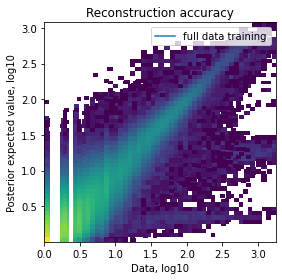

In [29]:
%%time

# read in reference signatures
inf_aver = pd.read_csv(f"{ref_run_name}/inf_aver.csv", index_col=0)

# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
print(f'shape of inf_aver: {inf_aver.shape}')
print('reference cell types')
print(inf_aver.columns)

for group in set(meta['cell2loc-map_group']):
    print(f'####### {group} #######')
    
    # subset adata
    adata_vis_sub=adata_vis[adata_vis.obs['cell2loc-map_group']==group].copy()
    samples = list(set(adata_vis_sub.obs['sample_for_cell2loc']))
    samples.sort()
    print(f'samples in this run: {samples}')
    adata_vis_sub=adata_vis_sub.copy()
    # prepare anndata for cell2location model
    scvi.data.setup_anndata(adata=adata_vis_sub, batch_key="sample_for_cell2loc")
    scvi.data.view_anndata_setup(adata_vis_sub)

    # create and train the model
    mod = cell2location.models.Cell2location(
        adata_vis_sub, cell_state_df=inf_aver, 
        # the expected average cell abundance: tissue-dependent 
        # hyper-prior which can be estimated from paired histology:
        N_cells_per_location=20,
        # hyperparameter controlling normalisation of
        # within-experiment variation in RNA detection (using default here):
        detection_alpha=20
    ) 

    mod.train(max_epochs=20000, 
              # train using full data (batch_size=None)
              batch_size=None, 
              # use all data points in training because 
              # we need to estimate cell abundance at all locations
              train_size=1,
              use_gpu=True)

    # plot ELBO loss history during training, removing first 100 epochs from the plot
    mod.plot_history(1000)
    plt.legend(labels=['full data training']);

    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    adata_vis_sub = mod.export_posterior(
        adata_vis_sub, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
    )

    # Save model
    mod.save(f"{run_name}/{group}", overwrite=True)

    # Save anndata object with results
    adata_vis_sub.write(f"{run_name}/{group}/sp.h5ad")

    # Examine reconstruction accuracy to assess if there are any issues with mapping
    # the plot should be roughly diagonal, strong deviations will signal problems
    mod.plot_QC()
    
    del mod,adata_vis_sub
    gc.collect()
    torch.cuda.empty_cache()